# Análise de sobrevivência aplicada ao e-commerce

## Objetivo

Aplicar a análise exploratória e análise de sobrevivência em dados de vendas de e-commerce com o objetivo de compreender o comportamento dos clientes compradores e gerar insumos para construção de estratégias em marketing.

## Base de dados

Os dados foram retirados do site [kaggle.com](https://www.kaggle.com/) e podem se acessados em [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce).

Os conjuntos de dados são de vendas de e-commerce pelo marketplace da empresa Olist e contemplam dados de vendas, clientes, avaliações, produtos, vendedores e geolocalização.

### Esquema do conjunto de dados
![alt text](./imagens/dataset_schema.png "Esquema de dados")

### Definição de escopo de análise

Considerando o objetivo da análise, o escopo será limitado à utilização das seguintes tabelas para a compreensão do comportamento de compras dos usuários:
* olist_orders_dataset
* olist_order_customer_dataset
* olist_order_payments_dataset
* olist_order_reviews_dataset
* olist_order_items_dataset
* olist_products_dataset

## Importação de bibliotecas

In [1]:
# Analise de tabelas
import pandas as pd
import numpy as np
import seaborn as sns
#pip install lifelines
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import matplotlib as matplotlib

## Leitura dos conjuntos de dados

In [2]:
customers_df = pd.read_csv('./dataset/customers_dataset.csv')
order_items_df = pd.read_csv('./dataset/order_items_dataset.csv')
order_payments_df = pd.read_csv('./dataset/order_payments_dataset.csv')
order_reviews_df = pd.read_csv('./dataset/order_reviews_dataset.csv')
orders_df = pd.read_csv('./dataset/orders_dataset.csv')
product_category_name_translation_df = pd.read_csv('./dataset/product_category_name_translation.csv')
products_df = pd.read_csv('./dataset/products_dataset.csv')

## Exploração e preparação de datasets

### Funções

In [3]:
def custom_barplot(df, x_colname, y_colname, title = ""):
    # Cria figura
    ax, fig = plt.subplots(figsize=(15,7))
    
    # Cria plot
    ax = sns.barplot(data = df,
                     x = x_colname,
                     y = y_colname)
    
    # Altera título do gráfico
    ax.set_title(title)
    
    # Rotação de label do eixo X
    for item in ax.get_xticklabels():
      item.set_rotation(45)
    
    return ax

### Ordens

In [4]:
# Informações básicas do dataset
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
# Visualização dos dados
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
# Contando valores nulos
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Nota-se que há pedidos que não foram entregues.

In [7]:
# Ordens por status
orders_df['order_status'].value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

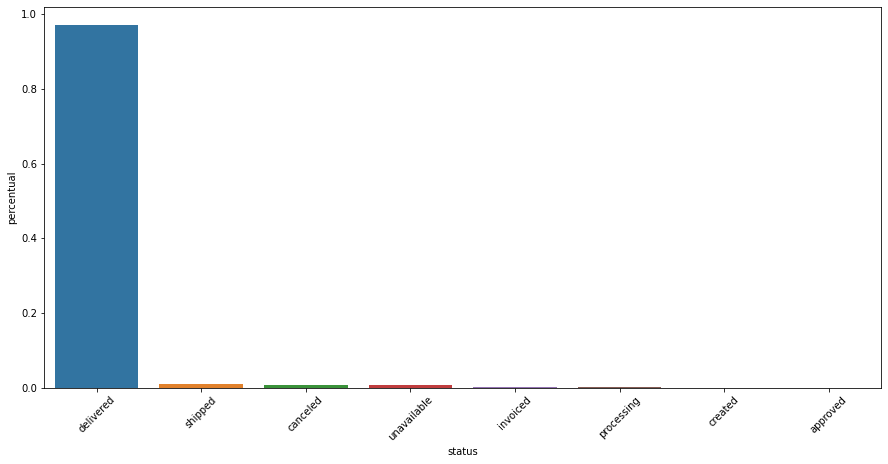

In [8]:
# Prepara dataframe para o plot
plot_orders_status = orders_df['order_status'].value_counts(normalize=True).reset_index()
plot_orders_status = plot_orders_status.rename(columns = {"index": "status", "order_status": "percentual"})

# Plot
custom_barplot(plot_orders_status, "status", "percentual")

#### Filtro de ordens
Para esta análise de sobrevivência o escopo será limitado apenas a pedidos com o status **delivered**, visto que estes representam aproximadamente **97%** de todos os pedidos realizados. Além disso, não há necessidade de manter todas as colunas, pois o evento de interesse é a data em que o pedido foi realizado.

In [9]:
delivered_orders = orders_df[orders_df['order_status'] == 'delivered']

delivered_orders = delivered_orders.drop(
    columns = [
        'order_approved_at', 
        'order_delivered_carrier_date', 
        'order_delivered_customer_date', 
        'order_estimated_delivery_date'
    ]
)

delivered_orders['order_status'].value_counts()

delivered    96478
Name: order_status, dtype: int64

In [10]:
delivered_orders.isna().sum()

order_id                    0
customer_id                 0
order_status                0
order_purchase_timestamp    0
dtype: int64

Retirando colunas que não serão utilizadas e pedidos que não foram entregues, foram retirados todos valores nulos no dataset e pode-se considerar que todas as compras presentes do novo dataset foram finalizadas com sucesso.

In [11]:
# Converte object para datetime
delivered_orders['order_purchase_timestamp'] = pd.to_datetime(delivered_orders['order_purchase_timestamp'])

In [12]:
# Cria coluna para year
delivered_orders['year'] = delivered_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y'))
# Convert coluna ano para Integer
delivered_orders['year'] = delivered_orders['year'].astype(int)

# Cria coluna para month
delivered_orders['month'] = delivered_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%m'))
# Convert coluna month para Integer
delivered_orders['month'] = delivered_orders['month'].astype(int)

# Cria coluna para nome do mês
delivered_orders['month_name'] = delivered_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))

# Cria coluna para mês e ano
delivered_orders['year_month'] = delivered_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b %Y'))

# Ordena vendas por data e hora
delivered_orders = delivered_orders.sort_values(by = ['order_purchase_timestamp'])

In [13]:
plot_orders_date = delivered_orders.groupby(by=['year', 'month', 'year_month'])['order_id'].count().reset_index().sort_values(by=['year', 'month'])
plot_orders_date = plot_orders_date.rename(columns = {"year_month": "data", "order_id": "quantidade"})

In [14]:
# Cria coluna com representação de percentual acumulado
plot_orders_date['percent'] = plot_orders_date['quantidade'].cumsum() / plot_orders_date['quantidade'].sum()

plot_orders_date

,year,month,data,quantidade,percent
0,2016,9,Sep 2016,1,0.000010
1,2016,10,Oct 2016,265,0.002757
2,2016,12,Dec 2016,1,0.002767
3,2017,1,Jan 2017,750,0.010541
4,2017,2,Feb 2017,1653,0.027675
5,2017,3,Mar 2017,2546,0.054064
6,2017,4,Apr 2017,2303,0.077935
7,2017,5,May 2017,3546,0.114689
8,2017,6,Jun 2017,3135,0.147184
9,2017,7,Jul 2017,3872,0.187317


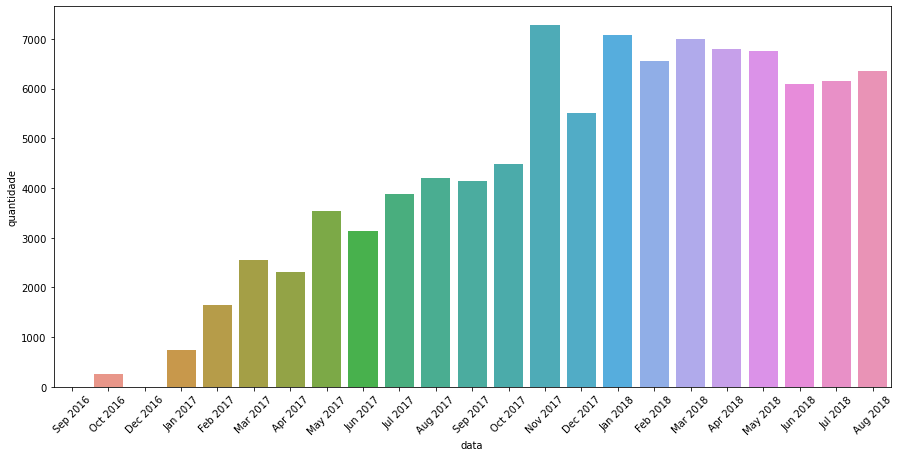

In [15]:
custom_barplot(plot_orders_date, "data", "quantidade")

In [16]:
delivered_orders = delivered_orders[delivered_orders['year'] > 2016]
delivered_orders = delivered_orders.reset_index()

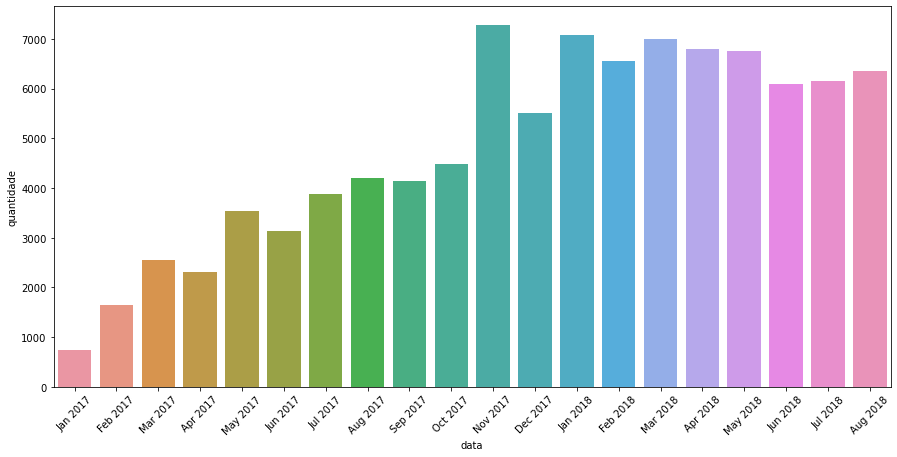

In [17]:
plot_orders_date = delivered_orders.groupby(by=['year', 'month', 'year_month'])['order_id'].count().reset_index().sort_values(by=['year', 'month'])
plot_orders_date = plot_orders_date.rename(columns = {"year_month": "data", "order_id": "quantidade"})

custom_barplot(plot_orders_date, "data", "quantidade")

In [18]:
delivered_orders.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,year,month,month_name,year_month
0,78768,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 11:56:06,2017,1,Jan,Jan 2017
1,16201,b95a0a8bd30aece4e94e81f0591249d8,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-05 12:01:20,2017,1,Jan,Jan 2017
2,74670,38bcb524e1c38c2c1b60600a80fc8999,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-05 12:06:36,2017,1,Jan,Jan 2017
3,15352,7a18a504c1a4b32d883e68de2e1a7db0,e6bee29442c761ff0dfb9a4414922a5c,delivered,2017-01-05 12:09:08,2017,1,Jan,Jan 2017
4,27002,6acecf438369055d9243e121045cca74,42d857e22f61f10476f0cda1aacc018a,delivered,2017-01-05 12:11:23,2017,1,Jan,Jan 2017


In [19]:
# Cria data final de análise
separation_date = pd.to_datetime('2018-05-01 00:00:00')

# Cria coluna purchase
delivered_orders['purchase'] = delivered_orders['order_purchase_timestamp'].apply(lambda x: 1 if x < separation_date else 0)

### Clientes

In [20]:
# Informações básicas do dataset
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [21]:
# Visualização dos dados
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [22]:
# Contando valores nulos
customers_df.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Não há valores nulos no dataset de **clientes**.

In [23]:
# Número de compras por cliente
customers_df['customer_unique_id'].value_counts().value_counts(normalize=True).sort_values(ascending=False)

1     0.968812
2     0.028565
3     0.002112
4     0.000312
5     0.000083
6     0.000062
7     0.000031
9     0.000010
17    0.000010
Name: customer_unique_id, dtype: float64

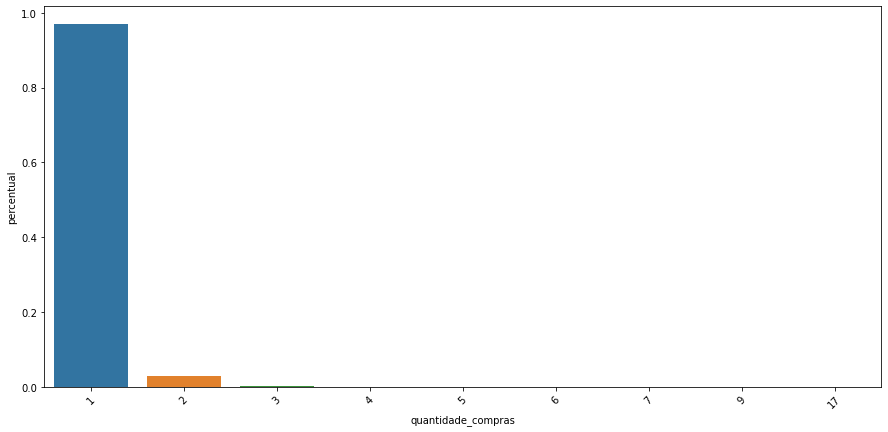

In [24]:
# Prepara dataframe para o plot
plot_customers_orders = customers_df['customer_unique_id'].value_counts().value_counts(normalize=True).reset_index()
plot_customers_orders = plot_customers_orders.rename(columns = {"index": "quantidade_compras", "customer_unique_id": "percentual"})

# Plot
custom_barplot(plot_customers_orders, "quantidade_compras", "percentual")

#### Filtro de clientes
Para a análise, serão considerados apenas clientes que realizaram apenas **1** compra, visto que estes representam 96,88% de todos os pedidos realizados no período e não serão analisados eventos recorrentes na aplicação de análise de sobrevivência. Além disso, para a seguinte análise pode-se considerar, além dos identificadores da tabela, apenas o atributo **customer_state**.

In [25]:
unique_purchase_ids = customers_df['customer_unique_id'].value_counts()[customers_df['customer_unique_id'].value_counts() == 1].index

unique_purchase_customers = customers_df[customers_df['customer_unique_id'].isin(unique_purchase_ids)]

unique_purchase_customers = unique_purchase_customers.drop(
    columns = [
        'customer_zip_code_prefix', 
        'customer_city',
    ]
)

unique_purchase_customers['customer_unique_id'].value_counts()

f7423590e53e055c672fb165a6a5c2de    1
a8cd58c8bf99980918e0177f7883dbf9    1
479346aff25d6c68b88e2927769b94d3    1
7e05679b11824f00a2ab44b5fe6934c7    1
648a5085600172967fa79c7bb045f574    1
                                   ..
cdb39bd368316f0f0ee48f0f6e42b03c    1
a013d464e12f7ff79241c06ff7b9f85a    1
ffdf72e25c6f0503bb567d0a8cf1c159    1
964eb1b98713e4527eb11bce9a0ac1fe    1
3020a77dc1ba0800c4905f73c5d95a1b    1
Name: customer_unique_id, Length: 93099, dtype: int64

In [26]:
unique_purchase_customers.head()

,customer_id,customer_unique_id,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP


### Itens

In [27]:
# Informações básicas do dataset
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [28]:
# Visualização dos dados
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [29]:
# Contando valores nulos
order_items_df.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Observa-se que o dataset de itens dos pedidos não possui valores nulos, e para o enriquecimento dos dados a base de itens será unificada à base de produtos.

In [30]:
# Verifica atributos do dataframe de produtos
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Destes atributos, **product_category_name** pode servir de aprofundamento da análise quanto a categoria de produtos.

In [31]:
# Join de itens e produtos do pedido
order_products = order_items_df.merge(products_df[['product_id', 'product_category_name']], how = 'left', on = 'product_id')

# Contagem de itens por pedido
order_products['order_id'].value_counts()

8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
428a2f660dc84138d969ccd69a0ab6d5    15
9ef13efd6949e4573a18964dd1bbe7f5    15
                                    ..
276473cdf80e80d33281cff1b5581166     1
9ccd75b5f3444a2dbf104b9cdc1183a1     1
518a29937a972f0eb47a811a8bf44642     1
cd95c47ac16f038d3b47edbcf984d942     1
8ee32c0f656d4816294802830cd9c2cd     1
Name: order_id, Length: 98666, dtype: int64

Cada pedido pode conter 1 ou mais itens. Considerando que um pedido pode conter diferentes categorias de produtos, pode-se fazer o tratamento utilizando variáveis *dummy*.

In [32]:
# Contagem de categoria de produtos
order_products['product_category_name'].unique().size

74

#### Conclusão
Caso os dados de categorias de produto sejam tratados como variáveis *dummy*, seriam adicionadas colunas para cada categoria de produto, totalizando 74 novas colunas. Este tratamento aumentaria expressivamente a complexidade da análise e não necessariamente apresentaria ganhos ao analisar o comportamento de compras de clientes em relação a um determinado período de tempo, logo a base de itens dos pedidos será excluída da análise.

### Pagamentos

In [33]:
# Informações básicas do dataset
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [34]:
# Visualização dos dados
order_payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [35]:
# Contando valores nulos
order_payments_df.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

A base de dados não contém valores nulos.

In [36]:
# Número de compras por usuário
order_payments_df['payment_type'].value_counts(normalize=True).sort_values(ascending=False)

credit_card    0.739224
boleto         0.190440
voucher        0.055590
debit_card     0.014718
not_defined    0.000029
Name: payment_type, dtype: float64

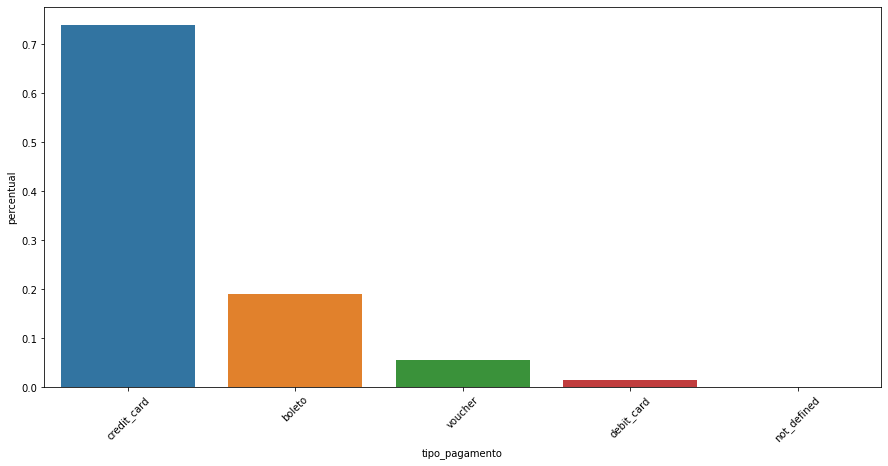

In [37]:
# Prepara dataframe para o plot
plot_payment_type = order_payments_df['payment_type'].value_counts(normalize=True).reset_index()
plot_payment_type = plot_payment_type.rename(columns = {"index": "tipo_pagamento", "payment_type": "percentual"})

# Plot
custom_barplot(plot_payment_type, "tipo_pagamento", "percentual")

#### Filtro de pagamentos
Apesar de não conter valores nulos, encontra-se formas de pagamento como **not_defined**. Devido a alta representatividade do método de pagamento **credit_card**, os métodos **boleto**, **voucher** e **debit_card** serão unidos e transformados na categoria **other_payment_type**. Para a análise, a base receberá os seguintes tratamentos:
* Pedidos com tipos de pagamento **not_defined** serão retirados da base.
* Exclusão das colunas **payment_sequential**, **payment_installments**.
* Transformação dos métodos de pagamento **boleto**, **voucher** e **debit_card** em **other_payment_type**.
* Agrupamento e transformação do atributo **payment_type** em variável *dummy*.
* Soma de registros agrupados para o atributo **payment_value**.

In [38]:
# Copia dataframe
payments_df = order_payments_df.copy()

# Remove valores not_defined
payments_df = payments_df[payments_df['payment_type'] != "not_defined"]

# Remove colunas payment_sequential e payment_installments
payments_df = payments_df.drop(
    columns = [
        'payment_sequential', 
        'payment_installments'
    ]
)

payments_df.head()

,order_id,payment_type,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,credit_card,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,credit_card,65.71
3,ba78997921bbcdc1373bb41e913ab953,credit_card,107.78
4,42fdf880ba16b47b59251dd489d4441a,credit_card,128.45


In [39]:
# Transforma atributo payment_type
payments_df['payment_type'] = payments_df['payment_type'].apply(lambda x: "credit_card" if x == "credit_card" else "other_payment_type")

#Agrupa atributos order_id e payment_type
payments_df = payments_df.groupby(by = ['order_id', 'payment_type']).sum().reset_index()

payments_df.head()

,order_id,payment_type,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,credit_card,72.19
1,00018f77f2f0320c557190d7a144bdd3,credit_card,259.83
2,000229ec398224ef6ca0657da4fc703e,credit_card,216.87
3,00024acbcdf0a6daa1e931b038114c75,credit_card,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,credit_card,218.04


In [40]:
# Cria variável dummy
payments_df = pd.get_dummies(payments_df, columns = ['payment_type']).groupby('order_id').sum().reset_index()

In [41]:
payments_df.head()

,order_id,payment_value,payment_type_credit_card,payment_type_other_payment_type
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,1,0
1,00018f77f2f0320c557190d7a144bdd3,259.83,1,0
2,000229ec398224ef6ca0657da4fc703e,216.87,1,0
3,00024acbcdf0a6daa1e931b038114c75,25.78,1,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,1,0


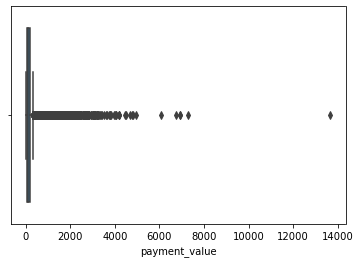

In [42]:
sns.boxplot(data = payments_df, x = 'payment_value')

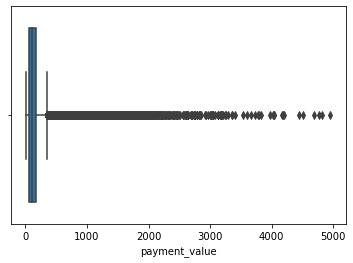

In [43]:
sns.boxplot(data = payments_df[payments_df['payment_value'] < 5000], x = 'payment_value')

In [44]:
def payment_category(value):
    if value <= 100:
        return "0.01 ~ 100.00"
    elif value > 100 and value <= 200:
        return "100.01 ~ 200.00"
    elif value > 200 and value <= 1000:
        return "200.01 ~ 1000.00"
    else:
        return "1000.01 ~ 5000.00"
    
payments_df['payment_category'] = payments_df['payment_value'].apply(payment_category)

Representatividade de valores dentro da base e limitação de valores até R$ 5000

Histograma com distribuição de até R$ 2000 para entender a distribuição

Avaliar variável pensando na importância desta variável para a predição.

### Avaliações

In [45]:
# Informações básicas do dataset
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [46]:
# Visualização dos dados
order_reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [47]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [48]:
order_reviews_df = order_reviews_df.drop(
    columns = [
        'review_comment_title', 
        'review_comment_message', 
        'review_answer_timestamp'
    ]
)

order_reviews_df.head()

,review_id,order_id,review_score,review_creation_date
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10 00:00:00
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17 00:00:00
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2017-04-21 00:00:00
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-01 00:00:00


In [49]:
# Contando valores nulos
order_reviews_df.isna().sum()

review_id               0
order_id                0
review_score            0
review_creation_date    0
dtype: int64

In [50]:
# Deixa apenas a última análise feita para cada pedido
order_reviews_df = order_reviews_df.sort_values('review_creation_date').groupby('order_id').tail(1).reset_index()

In [51]:
# Categoria avaliação
order_reviews_df['review_category'] = order_reviews_df['review_score'].apply(lambda x: 'ruim' if x <= 3 else 'boa')

order_reviews_df.head()

,index,review_id,order_id,review_score,review_creation_date,review_category
0,71485,69ac6a27fde9855ebeaaecac0f78058b,809a282bbd5dbcabb6f2f724fca862ec,1,2016-10-02 00:00:00,ruim
1,37828,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,2016-10-06 00:00:00,ruim
2,5538,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,2016-10-09 00:00:00,ruim
3,60918,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,2016-10-15 00:00:00,boa
4,41350,b2d5d8db2a841d27a72e4c06c6212368,9aa3197e4887919fde0307fc23601d7a,4,2016-10-15 00:00:00,boa


In [52]:
# Número de compras por usuário
order_reviews_df['order_id'].value_counts().sort_values(ascending=False)

8ee32c0f656d4816294802830cd9c2cd    1
3a62cd7c5ca5faeb968cbb94ad3d27bc    1
5546e31c47b50234b9ac599f2f8c0061    1
392ddca7a63143f9ec76350a09e0e138    1
f7923db0430587601c2aef15ec4b8af4    1
                                   ..
e5b8c6e3d666c6653f4eb12e402a0ece    1
f58d7e09ece55d81aac40b317757069e    1
ba39bd17a7fd2e7a495e6435781434ff    1
8f1e49888948febad9d7dc3ce8ec85c4    1
b6c8f27c95a4bcee39ea806f4e059ce9    1
Name: order_id, Length: 99441, dtype: int64

#### Filtro de avaliações
Para a análise, serão considerados apenas clientes que realizaram apenas **1** compra, visto que estes representam 96,88% de todos os pedidos realizados no período.

### Unindo bases de dados

Desta célula em diante será feito o processo de unificação (join) e enriquecimento entre os conjuntos de dados.

**Defender argurmento do porquê pegar a última avaliação.**

In [53]:
main_df = delivered_orders.merge(unique_purchase_customers, how = 'inner', on = 'customer_id')

In [54]:
main_df = main_df.merge(payments_df, how = 'inner', on = 'order_id')

In [55]:
main_df = main_df.merge(order_reviews_df, how = 'left', on = 'order_id')

In [56]:
main_df = main_df.drop(
    columns = [
        'index_x', 
        'index_y'
    ]
)

In [57]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90128 entries, 0 to 90127
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   order_id                         90128 non-null  object        
 1   customer_id                      90128 non-null  object        
 2   order_status                     90128 non-null  object        
 3   order_purchase_timestamp         90128 non-null  datetime64[ns]
 4   year                             90128 non-null  int32         
 5   month                            90128 non-null  int32         
 6   month_name                       90128 non-null  object        
 7   year_month                       90128 non-null  object        
 8   purchase                         90128 non-null  int64         
 9   customer_unique_id               90128 non-null  object        
 10  customer_state                   90128 non-null  object   

In [58]:
main_df['order_purchase_date'] = pd.to_datetime(main_df['order_purchase_timestamp']).dt.date

In [59]:
main_df['week_number'] = pd.to_datetime(main_df['order_purchase_date']).dt.week

In [60]:
def sum_week_day(year, week_day, wn2017):
    if year == 2018:
        return week_day + wn2017
    else:
        return week_day

wn2017 = main_df[main_df['year'] == 2017]['week_number'].max()

main_df['week_number'] = main_df.apply(lambda df: sum_week_day(df.year, df.week_number, wn2017), axis=1)

In [70]:
#main_df_test = main_df
main_df_test = main_df[main_df['order_purchase_timestamp'] < pd.to_datetime('2018-05-01 00:00:00')]

### Curva de sobrevivência

In [71]:
kmf = KaplanMeierFitter()

In [72]:
## Fit the data into the model
kmf.fit(main_df_test['week_number'], main_df_test['purchase'], label='Kaplan Meier Estimate')

<lifelines.KaplanMeierFitter:"Kaplan Meier Estimate", fitted with 66004 total observations, 0 right-censored observations>

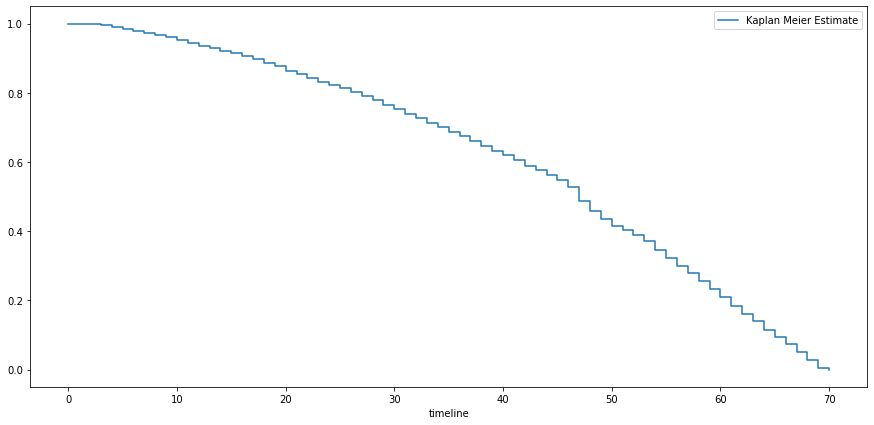

In [73]:
## Create an estimate
ax, fig = plt.subplots(figsize=(15,7))
kmf.plot(ci_show=False)

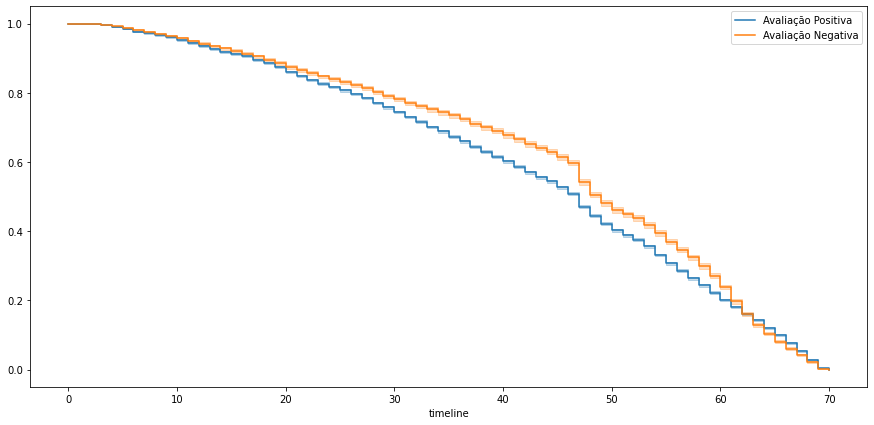

In [75]:
kmf1 = KaplanMeierFitter()
ax, fig = plt.subplots(figsize=(15,7))

## fit the model for 1st cohort
kmf1.fit(
    main_df_test[main_df_test['review_category'] == 'boa']['week_number'], 
    main_df_test[main_df_test['review_category'] == 'boa']['purchase'], 
    label='Avaliação Positiva')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(
    main_df_test[main_df_test['review_category'] == 'ruim']['week_number'], 
    main_df_test[main_df_test['review_category'] == 'ruim']['purchase'], 
    label='Avaliação Negativa')
kmf1.plot(ax=a1)

In [81]:
from lifelines.statistics import multivariate_logrank_test
# Tenure = tempo
# cat = Variável explicativa
# Churn = Variável resposta
p = multivariate_logrank_test(main_df_test['week_number'], main_df_test['review_category'], main_df_test['purchase'])

p

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          50.32 <0.005     39.48

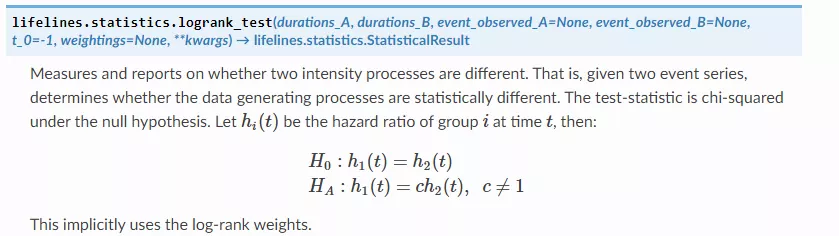

Confiança é o complemento do nível de significância (Confiança - Nível de significância = Acuracidade)

Considerando um nível de significância $\alpha=5\%$, $p-valor < 0,005 < \alpha=0,05$, assim sendo, rejeitamos a hipótese nula (h0) que diz que não há diferenças entre os tratamentos, ou seja, a variável *review_category* é significativa para a tarefa de explicar o evento *purchase*.

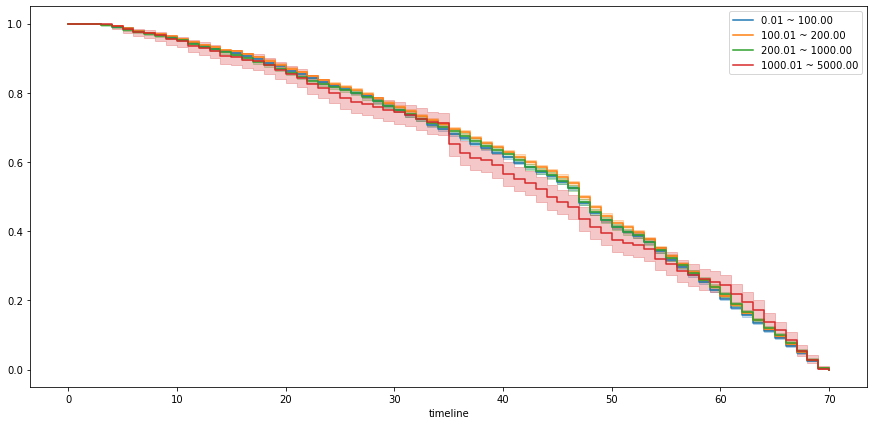

In [76]:
kmf2 = KaplanMeierFitter()

ax, fig = plt.subplots(figsize=(15,7))

## fit the model for 1st cohort
kmf2.fit(
    main_df_test[main_df_test['payment_category'] == '0.01 ~ 100.00']['week_number'], 
    main_df_test[main_df_test['payment_category'] == '0.01 ~ 100.00']['purchase'], 
    label='0.01 ~ 100.00')
a2 = kmf2.plot()

kmf2.fit(
    main_df_test[main_df_test['payment_category'] == '100.01 ~ 200.00']['week_number'], 
    main_df_test[main_df_test['payment_category'] == '100.01 ~ 200.00']['purchase'], 
    label='100.01 ~ 200.00')
a2 = kmf2.plot()

## fit the model for 2nd cohort
kmf2.fit(
    main_df_test[main_df_test['payment_category'] == '200.01 ~ 1000.00']['week_number'], 
    main_df_test[main_df_test['payment_category'] == '200.01 ~ 1000.00']['purchase'], 
    label='200.01 ~ 1000.00')
a2 = kmf2.plot()

kmf2.fit(
    main_df_test[main_df_test['payment_category'] == '1000.01 ~ 5000.00']['week_number'], 
    main_df_test[main_df_test['payment_category'] == '1000.01 ~ 5000.00']['purchase'], 
    label='1000.01 ~ 5000.00')
kmf2.plot(ax=a2)

In [80]:
from lifelines.statistics import multivariate_logrank_test
# Tenure = tempo
# cat = Variável explicativa
# Churn = Variável resposta
p = multivariate_logrank_test(main_df_test['week_number'], main_df_test['payment_category'], main_df_test['purchase'])

p

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
          12.43 0.01      7.37

Considerando um nível de significância $\alpha=5\%$, $p-valor = 0,01 < \alpha=5\%$, assim sendo, rejeitamos a hipótese nula (h0) que diz que não há diferenças entre os tratamentos, ou seja, a variável *payment_category* é significativa para a tarefa de explicar o evento *purchase*.